# Word Embeddings with a language model
This model is a version of the one introduced in 2003 by Bengio et all [here](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import os

## Data wikitext-2
The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia.

The data can be dowloaded here.
`https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip`

In [2]:
PATH=Path("/data/yinterian/wikitext-2")
list(PATH.iterdir())

[PosixPath('/data/yinterian/wikitext-2/wiki.train.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.valid.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.test.tokens'),
 PosixPath('/data/yinterian/wikitext-2/model.pth'),
 PosixPath('/data/yinterian/wikitext-2/mode117.pth')]

In [3]:
!head -4 /data/yinterian/wikitext-2/wiki.train.tokens

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 


## Tokenization / get vocab

In [4]:
def read_file(path):
    """ Read file returns a list of lines.
    """
    with open(path, encoding = "ISO-8859-1") as f:
        content = f.readlines()
    return content

In [5]:
train_lines = read_file(PATH/'wiki.train.tokens')
valid_lines = read_file(PATH/'wiki.valid.tokens')

In [6]:
len(train_lines), len(valid_lines)

(36718, 3760)

In [7]:
train_lines[10]

' The game \'s battle system , the <unk> system , is carried over directly from <unk> Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action <unk> . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede a character

In [8]:
from collections import defaultdict

def get_vocab(content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for line in content:
        words = set(line.split())
        for word in words:
            vocab[word] += 1
    return vocab

In [9]:
vocab = get_vocab(train_lines)

In [10]:
len(vocab)

33280

In [11]:
#vocab

## Creating a word2index

In [12]:
vocab2index = {}
words = []
for word in vocab:
    vocab2index[word] = len(words)
    words.append(word)

In [13]:
#vocab2index

## Encoding datasets

In [14]:
# there is an "unk" already
vocab2index['<unk>'] #[y for y in x for x in non_flat]

19

In [15]:
train_content = np.array([vocab2index.get(w, vocab2index["<unk>"]) for line in train_lines for w in line.split()])

In [16]:
val_content = np.array([vocab2index.get(w, vocab2index["<unk>"]) for line in valid_lines for w in line.split()])

In [17]:
train_content.shape, val_content.shape

((2051961,), (213886,))

## Dataset
Example say we have this dataset and we are using a window size of window=3.

Raw Dataset:
`the cat is walking in the bedroom`

`x                  y 
the cat is         walking 
cat is walking     in 
is walking in      the 
walking in the     bedroom` 

In [18]:
class WikiDataset(Dataset):
    def __init__(self, content, window=5):
        self.content = content
        self.window = window
        self.len = len(self.content) - self.window
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        x = self.content[idx : idx + self.window]
        y = self.content[idx + self.window]
        return x, y

In [19]:
dataset = WikiDataset([0,1,2,3,4,5,6], window=3)

In [20]:
print(len(dataset))
for i in range(4): 
    print(dataset[i])

4
([0, 1, 2], 3)
([1, 2, 3], 4)
([2, 3, 4], 5)
([3, 4, 5], 6)


In [21]:
train_ds = WikiDataset(train_content, window=5)
val_ds = WikiDataset(val_content, window=5)

In [22]:
batch_size = 4 # testing model
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## Model

In [23]:
class LangModel(nn.Module):
    """Lang Model that needs to be regularized."""

    def __init__(self, V, D, hidden, window=5, dropout=0.5):
        super(LangModel, self).__init__()
        self.word_emb = nn.Embedding(V, D)
        self.linear1 = nn.Linear(window*D, hidden)
        self.dense_bn1 = nn.BatchNorm1d(hidden)
        self.linear2 = nn.Linear(hidden, V)

    def forward(self, x):
        x = self.word_emb(x)
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = F.relu(self.dense_bn1(x))
        x = self.linear2(x)
        return x

In [24]:
x, y = next(iter(train_dl))

In [25]:
x, y

(tensor([[  143, 12674,     5,     3,     3],
         [   59,  3071,     7,   188,    65],
         [  337,    65,  4681,  2103, 10499],
         [   83, 11647,    65,  1748, 11866]]), tensor([  3, 247,  72,   5]))

In [26]:
x.size(0)

4

In [27]:
V = len(vocab)
D = 3 # for testing

In [28]:
word_emb = nn.Embedding(V, D)

In [29]:
x1 = word_emb(x)
x1

tensor([[[ 1.1896,  0.3813, -1.0437],
         [-2.5420,  1.1579,  1.5254],
         [-0.4364,  0.0629, -1.2389],
         [-0.6150, -0.6007, -1.0478],
         [-0.6150, -0.6007, -1.0478]],

        [[ 0.4863,  0.2596,  0.5871],
         [-1.0439, -0.5869, -1.2581],
         [-0.5645, -0.5120,  0.8133],
         [-0.8718,  0.2595,  0.7135],
         [-0.5934,  1.4313, -0.8278]],

        [[ 0.4297,  0.7937,  0.9868],
         [-0.5934,  1.4313, -0.8278],
         [-1.0084, -0.4667,  1.2358],
         [ 0.8987,  0.0916, -0.9026],
         [-0.3846,  1.4131,  1.8568]],

        [[ 0.4838, -0.4012, -0.3694],
         [ 0.7983,  0.4171,  0.2032],
         [-0.5934,  1.4313, -0.8278],
         [ 0.7160, -1.1515,  1.8237],
         [-0.6277, -0.1911, -1.5470]]], grad_fn=<EmbeddingBackward>)

In [30]:
x2 = x1.view(x1.shape[0], -1)
x2

tensor([[ 1.1896,  0.3813, -1.0437, -2.5420,  1.1579,  1.5254, -0.4364,  0.0629,
         -1.2389, -0.6150, -0.6007, -1.0478, -0.6150, -0.6007, -1.0478],
        [ 0.4863,  0.2596,  0.5871, -1.0439, -0.5869, -1.2581, -0.5645, -0.5120,
          0.8133, -0.8718,  0.2595,  0.7135, -0.5934,  1.4313, -0.8278],
        [ 0.4297,  0.7937,  0.9868, -0.5934,  1.4313, -0.8278, -1.0084, -0.4667,
          1.2358,  0.8987,  0.0916, -0.9026, -0.3846,  1.4131,  1.8568],
        [ 0.4838, -0.4012, -0.3694,  0.7983,  0.4171,  0.2032, -0.5934,  1.4313,
         -0.8278,  0.7160, -1.1515,  1.8237, -0.6277, -0.1911, -1.5470]],
       grad_fn=<ViewBackward>)

In [31]:
x2.shape

torch.Size([4, 15])

## Testing model

In [32]:
V = len(vocab)
D = 50
model = LangModel(V, D, hidden=15).cuda()

In [33]:
x, y = next(iter(train_dl))

In [34]:
x = x.cuda()

In [35]:
y_hat = model(x)

In [36]:
y_hat

tensor([[ 0.2638,  0.0213,  0.1190,  ..., -0.2202, -0.3349,  0.0259],
        [ 0.2928, -0.3325,  0.4515,  ..., -0.3163, -0.6589, -0.1121],
        [ 0.1962,  0.2472,  0.0485,  ..., -0.2298, -0.5431, -0.1626],
        [-0.0775,  0.0145, -0.5498,  ...,  0.4065,  0.3443,  0.6282]],
       device='cuda:0', grad_fn=<AddmmBackward>)

## Training

`F.cross_entropy` combines `log_softmax` and `nll_loss` in a single function.

In [37]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

In [38]:
def train_epocs(model, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(epochs):
        model.train()
        total = 0
        total_loss = 0.
        for x, y in train_dl:
            x = torch.LongTensor(x).cuda()
            y = torch.LongTensor(y).cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss +=  x.size(0)* loss.item()
            total += x.size(0)
        val_loss = val_metrics(model)
        print("train_loss %.3f val_loss %.3f perplexity %.3f" % (total_loss/total, 
                                                                 val_loss, math.exp(val_loss)))

In [39]:
import math
def val_metrics(model):
    model.eval()
    total = 0
    total_loss = 0.
    for x,y in val_dl:
        x = torch.LongTensor(x).cuda()
        y = torch.LongTensor(y).cuda()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        total_loss +=  x.size(0)* loss.item()
        total += x.size(0)
    return total_loss/ total

In [40]:
V = len(vocab)
D = 50
model = LangModel(V, D, hidden=15).cuda()

In [41]:
val_metrics(model)

10.440684290446596

In [42]:
train_epocs(model, epochs=10, lr=0.01)

train_loss 6.583 val_loss 5.904 perplexity 366.390
train_loss 5.819 val_loss 5.610 perplexity 273.271
train_loss 5.609 val_loss 5.448 perplexity 232.385
train_loss 5.480 val_loss 5.341 perplexity 208.666
train_loss 5.389 val_loss 5.261 perplexity 192.649
train_loss 5.319 val_loss 5.199 perplexity 181.113
train_loss 5.263 val_loss 5.144 perplexity 171.485
train_loss 5.215 val_loss 5.100 perplexity 164.055
train_loss 5.174 val_loss 5.062 perplexity 157.843
train_loss 5.138 val_loss 5.026 perplexity 152.298


In [45]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [46]:
save_model(model, PATH/"model10.pth")

In [47]:
train_epocs(model, epochs=10, lr=0.01)

train_loss 5.173 val_loss 5.014 perplexity 150.565
train_loss 5.081 val_loss 4.969 perplexity 143.948
train_loss 5.048 val_loss 4.940 perplexity 139.776
train_loss 5.020 val_loss 4.914 perplexity 136.227
train_loss 4.996 val_loss 4.890 perplexity 132.946
train_loss 4.973 val_loss 4.869 perplexity 130.176
train_loss 4.953 val_loss 4.849 perplexity 127.601
train_loss 4.934 val_loss 4.830 perplexity 125.264
train_loss 4.916 val_loss 4.813 perplexity 123.074
train_loss 4.899 val_loss 4.795 perplexity 120.900


In [48]:
save_model(model, PATH/"model20.pth")

## Learning rate finder

In [50]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-3, lr_high=1, epochs=5):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/(iterations-1)
    losses = []
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    total_loss = 0
    for i in range(epochs):
        for x, y in train_dl:
            lr = lrs[ind]
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            x = torch.LongTensor(x).cuda()
            y = torch.LongTensor(y).cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            losses.append(loss.item())
            ind += 1
    return lrs, losses 

In [51]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

V = len(vocab)
D = 50
model = LangModel(V, D, hidden=15).cuda()
lrs, losses = LR_range_finder(model, train_dl)

In [52]:
len(lrs)

2055

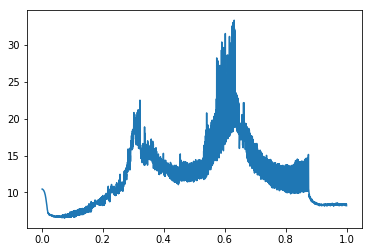

In [57]:
import matplotlib.pyplot as plt 
plt.plot(lrs, losses)
plt.show()

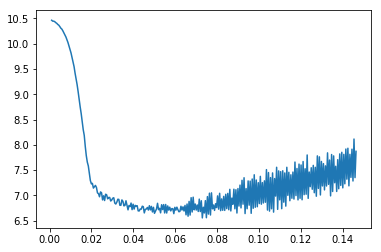

In [58]:
plt.plot(lrs[:300], losses[:300])
plt.show()

In [107]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

V = len(vocab)
D = 50
model = LangModel(V, D, hidden=15).cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1)

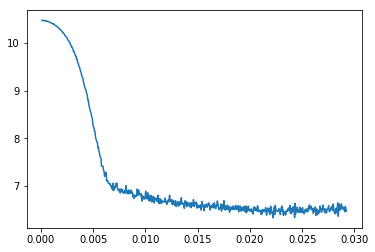

In [111]:
plt.plot(lrs[:600], losses[:600])
plt.show()

In [59]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [103]:
lrs = get_triangular_lr2(lr_low=1e-4, lr_high=0.05, iterations=800)

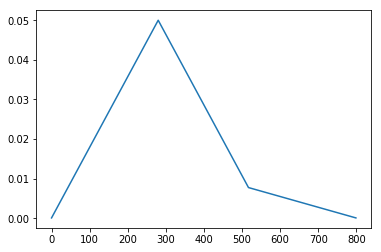

In [106]:
plt.plot(list(range(len(lrs))), lrs)
plt.show()

In [85]:
import time
def train_triangular_policy(model, epochs=4, lr_low=1e-4, lr_high=0.05):
    start_time = time.time()
    
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/(iterations-1)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    
    ind = 0
    for i in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl:
            lr = lrs[ind]
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            x = torch.LongTensor(x).cuda()
            y = torch.LongTensor(y).cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ind += 1
            total_loss += x.size(0) * loss.item()
            total += x.size(0)
        val_loss = val_metrics(model)
        train_loss = total_loss / total
            
        print('| epoch {:3d} | lr {:02.5f} | train_loss {:5.2f} | val_loss {:5.2f} | val_ppl {:5.2f}'.format(
             i, lr, train_loss, val_loss, math.exp(val_loss)))

In [99]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size=10000, shuffle=False)

V = len(vocab)
D = 50
model = LangModel(V, D, hidden=15).cuda()

In [100]:
train_triangular_policy(model, epochs=25, lr_low=1e-3, lr_high=0.015)

| epoch   0 | lr 0.00260 | train_loss  8.23 | val_loss  6.81 | val_ppl 905.70
| epoch   1 | lr 0.00420 | train_loss  6.66 | val_loss  6.56 | val_ppl 703.21
| epoch   2 | lr 0.00580 | train_loss  6.51 | val_loss  6.46 | val_ppl 638.48
| epoch   3 | lr 0.00740 | train_loss  6.45 | val_loss  6.43 | val_ppl 619.99
| epoch   4 | lr 0.00900 | train_loss  6.43 | val_loss  6.43 | val_ppl 617.35
| epoch   5 | lr 0.01060 | train_loss  6.43 | val_loss  6.40 | val_ppl 600.95
| epoch   6 | lr 0.01220 | train_loss  6.39 | val_loss  6.35 | val_ppl 571.71
| epoch   7 | lr 0.01380 | train_loss  6.35 | val_loss  6.33 | val_ppl 558.81
| epoch   8 | lr 0.01460 | train_loss  6.36 | val_loss  6.34 | val_ppl 566.34
| epoch   9 | lr 0.01300 | train_loss  6.40 | val_loss  6.43 | val_ppl 619.89
| epoch  10 | lr 0.01140 | train_loss  6.52 | val_loss  6.53 | val_ppl 684.76
| epoch  11 | lr 0.00980 | train_loss  6.41 | val_loss  6.34 | val_ppl 569.47
| epoch  12 | lr 0.00820 | train_loss  6.36 | val_loss  6.30 | v

In [ ]:
p = PATH/"mode1-tri-10.pth"
save_model(model, str(p))

## References
